In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
import matplotlib
matplotlib.rc('font', size=14)
plt.rc('axes', titlesize=24)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Palatino"
# })

In [2]:
f = open('ratelaw_nn_sigmoid_data_rescaled.pickle', 'rb')
sigmoid_data = pkl.load(f)

In [3]:
Ai = [(i)/10 for i in range(2,20)]

In [4]:
true_temp = np.genfromtxt('true_temp.csv', delimiter=',')
true_temp = true_temp[1, 1:]

In [5]:
sigmoid_profile = sigmoid_data['temp']['local_reduced']
sigmoid_profile_mean = np.median(sigmoid_profile, axis = 1)[1:]
sigmoid_profile_std = np.std(sigmoid_profile, axis = 1)[1:]

In [6]:
alamo_profile = np.genfromtxt('alamo_output_temp.csv', delimiter=',')
alamo_profile_mean = np.median(alamo_profile[1:], axis = 0)[1:]
alamo_profile_std = np.std(alamo_profile[1:], axis = 0)[1:]

In [7]:
io_profile = np.genfromtxt('io_output_temp.csv', delimiter=',')
io_profile_mean = np.mean(io_profile[1:], axis = 0)[1:]
io_profile_std = np.std(io_profile[1:], axis = 0)[1:]

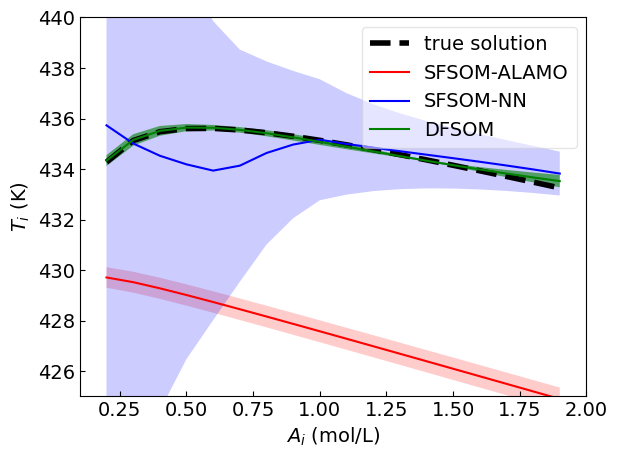

In [10]:
fig, ax = plt.subplots()
ax.plot(Ai, true_temp, color = "black", linewidth = 4, linestyle = "dashed", label = "true solution")
ax.plot(Ai, alamo_profile_mean, '-', color = "red", label = "SFSOM-ALAMO")
ax.fill_between(Ai, alamo_profile_mean - alamo_profile_std, alamo_profile_mean + alamo_profile_std, alpha=0.2, facecolor = "red")
ax.plot(Ai, sigmoid_profile_mean, '-', color = "blue", label = "SFSOM-NN")
ax.fill_between(Ai, sigmoid_profile_mean - sigmoid_profile_std, sigmoid_profile_mean + sigmoid_profile_std, alpha=0.2, facecolor = "blue")
ax.plot(Ai, io_profile_mean, '-', color = "green", label = "DFSOM")
ax.fill_between(Ai, io_profile_mean - io_profile_std, io_profile_mean + io_profile_std, alpha=0.6, facecolor = "green")
ax.tick_params(direction = "in")
plt.xlim(0.1, 2)
# ax.set_xticklabels([0.1, 0.5, 1.0, 1.5, 2.0], fontsize = 12)
plt.ylim(425, 440)
plt.xlabel('$A_i$ (mol/L)')
plt.ylabel('$T_i$ (K)')
fig.tight_layout()
plt.legend(fancybox = True, framealpha=0.5)
plt.savefig('embedded_comparison.pdf', transparent = True)

# Get the feasible regions

In [11]:
# CSTR parameters
C1 = 5e3 # 1/s
Cm1 = 1e6 # 1/s
Q = 10000 # cal/mol
Qm1 = 15000 # cal/mol
gc = 1.987 # cal/mol.K
tau = 60 # s
dH = -5000 # cal/mol
rho = 1.0 # kg/L
cp = 1000 # cal/kg.K

In [12]:
# true feasible region
def true_feas_region(Ai, Ti):
    m = pyo.ConcreteModel()
    m.A = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.R = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.T = pyo.Var(domain=pyo.NonNegativeReals, initialize = 425)
    m.k1 = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.km1 = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
  
    # Objective
    m.cost = pyo.Objective(expr = 0, sense = pyo.maximize)

    m.equal1 = pyo.Constraint(expr = m.k1 == C1*pyo.exp(-Q/(gc*m.T)))
    m.equal2 = pyo.Constraint(expr = m.km1 == Cm1*pyo.exp(-Qm1/(gc*m.T)))

    m.A_balance = pyo.Constraint(expr = 0 == 1/tau * (Ai - m.A) - m.k1*m.A + m.km1*m.R)
    m.R_balance = pyo.Constraint(expr = 0 == 1/tau * (0 - m.R) + m.k1*m.A - m.km1*m.R)
    m.energy = pyo.Constraint(expr = 0 == -dH/(rho*cp) * (m.k1*m.A - m.km1*m.R) + 1/tau * (Ti - m.T))
    solver = pyo.SolverFactory('ipopt', executable='ipopt').solve(m, tee=False)
    return pyo.value(m.R())

In [13]:
def true_opt_temp(Ai):
    m = pyo.ConcreteModel()
    m.A = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.R = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.T = pyo.Var(domain=pyo.NonNegativeReals, initialize = 425)
    m.k1 = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.km1 = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.Ti = pyo.Var(domain=pyo.NonNegativeReals, initialize = 425)
  
    # Objective
    m.cost = pyo.Objective(expr = 2.009*m.R - (1.657e-3*(m.Ti - 410))**2, sense = pyo.maximize)

    m.equal1 = pyo.Constraint(expr = m.k1 == C1*pyo.exp(-Q/(gc*m.T)))
    m.equal2 = pyo.Constraint(expr = m.km1 == Cm1*pyo.exp(-Qm1/(gc*m.T)))

    m.A_balance = pyo.Constraint(expr = 0 == 1/tau * (Ai - m.A) - m.k1*m.A + m.km1*m.R)
    m.R_balance = pyo.Constraint(expr = 0 == 1/tau * (0 - m.R) + m.k1*m.A - m.km1*m.R)
    m.energy = pyo.Constraint(expr = 0 == -dH/(rho*cp) * (m.k1*m.A - m.km1*m.R) + 1/tau * (m.Ti - m.T))
    solver = pyo.SolverFactory('ipopt', executable='ipopt').solve(m, tee=False)
    return pyo.value(m.Ti()), pyo.value(m.R())

In [14]:
from omlt import OmltBlock, OffsetScaling
from omlt.io import load_keras_sequential
from omlt.neuralnet import FullSpaceSmoothNNFormulation
import pyomo.environ as pyo
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

2023-05-04 17:09:59.824633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
np.random.seed(12345)
columns = ['A_0', 'R_0', 'T_0', 'r']
inputs = ['A_0', 'R_0', 'T_0']
outputs = ['r']
df = pd.read_csv('training_data.csv', usecols=columns)
dfin = df[inputs]
dfout = df[outputs]

# create our Sequential model
nn = Sequential(name='nn_sigmoid_4_10')
nn.add(Dense(units=10, input_dim=len(inputs), activation='sigmoid'))
nn.add(Dense(units=10, activation='sigmoid'))
nn.add(Dense(units=10, activation='sigmoid'))
nn.add(Dense(units=10, activation='sigmoid'))
nn.add(Dense(units=len(outputs)))
nn.compile(optimizer=Adam(), loss='mse')

# train our model with random data
n_train = 3000
train_idx = np.random.choice(dfin.shape[0], n_train, replace=False)

# scale the inputs and outputs
x_offset, x_factor = dfin.iloc[train_idx].mean().to_dict(), dfin.iloc[train_idx].std().to_dict()
y_offset, y_factor = dfout.iloc[train_idx].mean().to_dict(), dfout.iloc[train_idx].std().to_dict()
dfin = (dfin - dfin.iloc[train_idx].mean()).divide(dfin.iloc[train_idx].std())
dfout = (dfout - dfout.iloc[train_idx].mean()).divide(dfout.iloc[train_idx].std())

scaled_lb = dfin.min()[inputs].values
scaled_ub = dfin.max()[inputs].values

scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

# Create OMLT object required to unscale the nn output later
scaler = OffsetScaling(
    offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
    factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
    offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
    factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))}
)
x = dfin.iloc[train_idx].values
y = dfout.iloc[train_idx].values
history = nn.fit(x, y, epochs=1500, verbose = False)

2023-05-04 17:10:20.158767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# NN feasible region
def feas_region(Ai, Ti):
    m = pyo.ConcreteModel()
    # create the OmltBlock to hold the neural network model
    m.reformer = OmltBlock()
    # create a network definition from the Keras model
    net = load_keras_sequential(nn, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds)

    # create the variables and constraints for the neural network in Pyomo
    m.reformer.build_formulation(FullSpaceSmoothNNFormulation(net))
    A0_idx = inputs.index('A_0')
    R0_idx = inputs.index('R_0')
    T0_idx = inputs.index('T_0')
    r_idx = outputs.index('r')
    # m.Ti = pyo.Var(domain=pyo.NonNegativeReals)

    # Objective
    m.cost = pyo.Objective(expr = 0, sense = pyo.maximize)

    # Constraints
    m.A_balance = pyo.Constraint(expr = 1/tau*(Ai - m.reformer.inputs[A0_idx]) - m.reformer.outputs[r_idx] == 0)
    m.R_balance = pyo.Constraint(expr = 1/tau*(0 - m.reformer.inputs[R0_idx]) + m.reformer.outputs[r_idx] == 0)
    m.energy = pyo.Constraint(expr = 1/tau*(Ti - m.reformer.inputs[T0_idx]) + (-dH/(rho*cp)*m.reformer.outputs[r_idx]) == 0)
    # m.pprint()
    solver = pyo.SolverFactory('ipopt', executable='ipopt').solve(m, tee=False)
    return pyo.value(m.reformer.inputs[R0_idx])

In [17]:
# ALAMO feasible region
def alamo_feas_region(Ai, Ti):
    m = pyo.ConcreteModel()
    m.A = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.R = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.T = pyo.Var(domain=pyo.NonNegativeReals, initialize = 425)
    m.rate = pyo.Var(domain=pyo.Reals)
  
    # Objective
    m.cost = pyo.Objective(expr = 0, sense = pyo.maximize)

    m.r = pyo.Constraint(expr = m.rate == - 9.6674517866367981611120 * m.A + 21.089076857998897196467 * m.R + 0.11816373751977610195851E-001 * m.A*m.T - 0.24853580746539160467590E-001 * m.R*m.T + 1987.6487778808855182433 * m.A/m.T - 4475.8512690759753240854 * m.R/m.T)
    m.A_balance = pyo.Constraint(expr = 0 == 1/tau * (Ai - m.A) - m.rate)
    m.R_balance = pyo.Constraint(expr = 0 == 1/tau * (0 - m.R) + m.rate)
    m.energy = pyo.Constraint(expr = 0 == -dH/(rho*cp) * m.rate + 1/tau * (Ti - m.T))
    solver = pyo.SolverFactory('ipopt', executable='ipopt').solve(m, tee=False)
    return pyo.value(m.R())

In [18]:
# IO fesible region
def io_feas_region(Ai, Ti):
#     P = np.array([[0.000705797,0.0,-2.28661e-5,0.0],[3.15133,2.7618,3.50933,7.9586],[0.000252642,-0.00256216,0.00609191,1.4482e-5],[3.04273,3.49175,5.59708,2.39061]])
    P = np.array([[0.00015312418582235068,0.00012240816675025337,0.00014207248588332953,-3.465684279002526e-5], [1.4063993423261487,1.213401231700289,1.4479566759281703,0.1612437673769599], [0.0,0.0,-2.7551310708667594e-6,5.844054935979412e-6], [1.357865850276509,1.2558556681469204,1.657404439622345,0.12242142259466371]])

    a = np.zeros(4)
    for i in range(4):
        a[i] = P[i, 0]*Ai**3 + P[i, 1]*Ai**2 + P[i, 2]*Ai + P[i, 3]

    m = pyo.ConcreteModel()
    m.A = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.R = pyo.Var(domain=pyo.NonNegativeReals, initialize = 0)
    m.T = pyo.Var(domain=pyo.NonNegativeReals, initialize = 425)
    m.rate = pyo.Var(domain=pyo.Reals)
    # Objective
    m.cost = pyo.Objective(expr = 0, sense = pyo.maximize)

    m.r = pyo.Constraint(expr = m.rate == (a[0]*m.T + a[1]*m.A) - (a[2]*m.T + a[3]*m.R))
    m.A_balance = pyo.Constraint(expr = 0 == 1/tau * (Ai - m.A) - m.rate)
    m.R_balance = pyo.Constraint(expr = 0 == 1/tau * (0 - m.R) + m.rate)
    m.energy = pyo.Constraint(expr = 0 == -dH/(rho*cp) * m.rate + 1/tau * (Ti - m.T))
    solver = pyo.SolverFactory('ipopt', executable='ipopt').solve(m, tee=False)
    return pyo.value(m.R())

In [19]:
Ai = [0.3, 0.6, 1]
true_solutions = [true_opt_temp(Ai[i]) for i in range(len(Ai))]
Ti = [400+i for i in range(0,121,5)]
true_feas = np.empty([len(Ti), len(Ai)])
alamo_feas = np.empty([len(Ti), len(Ai)])
nn_feas = np.empty([len(Ti), len(Ai)])
io_feas = np.empty([len(Ti), len(Ai)])
for i in range(len(Ai)):
    for j in range(len(Ti)):
        true_feas[j, i] = true_feas_region(Ai[i], Ti[j])
        nn_feas[j, i] = feas_region(Ai[i], Ti[j])
        alamo_feas[j, i] = alamo_feas_region(Ai[i], Ti[j])
        io_feas[j, i] = io_feas_region(Ai[i], Ti[j])

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.


In [20]:
true_solutions

[(435.1273134270461, 0.15254604593560764),
 (435.60928858063977, 0.30522094501969016),
 (435.13599317823036, 0.5087519807102427)]

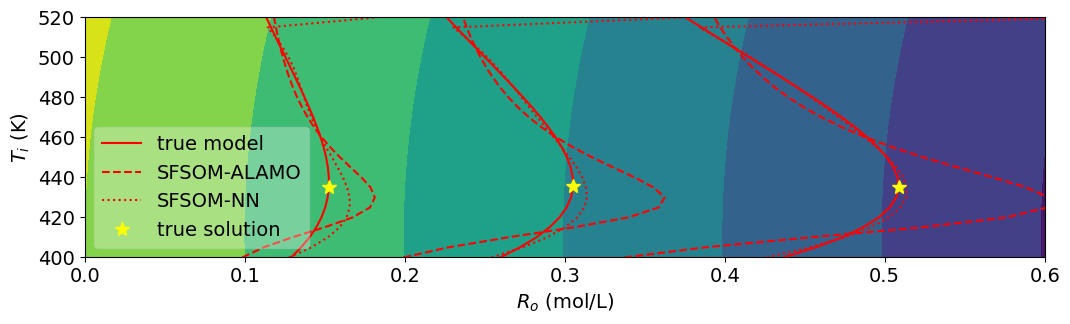

In [21]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

# First we prepare the contour for the background
fig = plt.figure(figsize=(24, 12))
adjustFigAspect(fig,aspect=4)
ax = fig.add_subplot(111)
x = np.linspace(0, 0.6, 101)
y = np.linspace(400, 520, 101)
# full coordinate arrays
xx, yy = np.meshgrid(x, y)
zz = -2.009*xx + (1.657e-3*(yy-410))**2
h = ax.contourf(x, y, zz)
ax.plot(true_feas[:, 0], Ti, color = "red", label = "true model")
ax.plot(alamo_feas[:, 0], Ti, color = "red", linestyle = "dashed", label = "SFSOM-ALAMO")
ax.plot(nn_feas[:, 0], Ti, color = "red", linestyle = "dotted", label = "SFSOM-NN")
ax.plot(true_feas[:, 1:], Ti, color = "red")
ax.plot(alamo_feas[:, 1:], Ti, color = "red", linestyle = "dashed")
ax.plot(nn_feas[:, 1:], Ti, color = "red", linestyle = "dotted")
ax.plot(true_solutions[0][1], true_solutions[0][0], marker="*", markersize=10, markeredgecolor="yellow",markerfacecolor="yellow", linestyle="None", label = "true solution")
for i in range(1,3):
    ax.plot(true_solutions[i][1], true_solutions[i][0], marker="*", markersize=10, markeredgecolor="yellow", linestyle="None", markerfacecolor="yellow")
ax.legend(fancybox = True, framealpha = 0.3)
plt.xlim([0,0.6])
plt.xlabel('$R_o$ (mol/L)')
plt.ylabel('$T_i$ (K)')
plt.savefig('feas_region_comp_true_obj_1.pdf', bbox_inches="tight", transparent = True)

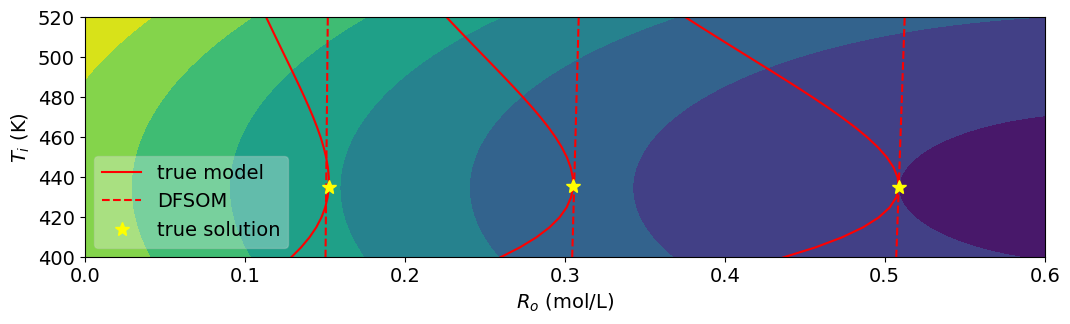

In [22]:
# First we prepare the contour for the background
fig = plt.figure(figsize=(24, 12))
adjustFigAspect(fig,aspect=4)
ax = fig.add_subplot(111)
x = np.linspace(0, 0.6, 101)
y = np.linspace(400, 520, 101)
# full coordinate arrays
xx, yy = np.meshgrid(x, y)
Qc = np.array([84413.08289438886, -107955.83180759274, 1.0, -869.3111397164283])
zz = Qc[0]*xx**2 + Qc[1]*xx + Qc[2]*yy**2 + Qc[3]*yy
h = ax.contourf(x, y, zz)
ax.plot(true_feas[:, 0], Ti, color = "red", label = "true model")
ax.plot(io_feas[:, 0], Ti, color = "red", linestyle = "dashed", label = "DFSOM")
ax.plot(true_feas[:, 1:], Ti, color = "red")
ax.plot(io_feas[:, 1:], Ti, color = "red", linestyle = "dashed")
ax.plot(true_solutions[0][1], true_solutions[0][0], marker="*", markersize=10, markeredgecolor="yellow",markerfacecolor="yellow", linestyle="None", label = "true solution")
for i in range(1,3):
    ax.plot(true_solutions[i][1], true_solutions[i][0], marker="*", markersize=10, markeredgecolor="yellow", linestyle="None", markerfacecolor="yellow")
ax.legend(fancybox = True, framealpha = 0.3)
plt.xlabel('$R_o$ (mol/L)')
plt.ylabel('$T_i$ (K)')
plt.savefig('feas_region_comp_IO_obj_1.pdf', bbox_inches="tight", transparent = True)